<a href="https://colab.research.google.com/github/vferman2000/Springboard/blob/master/Ultimate_Technologies_Predicting_Modeling_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Analysis Interview Challenge

# Predicting Modeling

Ultimate is interested in predicting rider retention. To help explore this question, we have
provided a sample dataset of a cohort of users who signed up for an Ultimate account in January 2014. The data was pulled several months later; we consider a user retained if they
were “active” (i.e. took a trip) in the preceding 30 days.
We would like you to use this data set to help understand what factors are the best predictors
for retention, and offer suggestions to operationalize those insights to help Ultimate.
The data is in the attached file ultimate_data_challenge.json. See below for a detailed
description of the dataset. Please include any code you wrote for the analysis and delete the
dataset when you have finished with the challenge.
1. Perform any cleaning, exploratory analysis, and/or visualizations to use the provided
data for this analysis (a few sentences/plots describing your approach will suffice). What
fraction of the observed users were retained?
2. Build a predictive model to help Ultimate determine whether or not a user will be active
in their 6th month on the system. Discuss why you chose your approach, what
alternatives you considered, and any concerns you have. How valid is your model?
Include any key indicators of model performance.
3. Briefly discuss how Ultimate might leverage the insights gained from the model to
improve its longterm
rider retention (again, a few sentences will suffice).

In [1]:
#Importing libraries
import pandas as pd
import json
from pandas.io.json import json_normalize
import numpy as np
import random
import datetime as dt
import matplotlib.pyplot as plt


In [2]:
from google.colab import files
def getLocalFiles():
    _files = files.upload()
    if len(_files) >0:
       for k,v in _files.items():
         open(k,'wb').write(v)
getLocalFiles()

Saving ultimate_data_challenge1.json to ultimate_data_challenge1.json


In [3]:
data = pd.read_json('/content/ultimate_data_challenge1.json', orient='split')

In [4]:
data.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    50000 non-null  object 
 1   trips_in_first_30_days  50000 non-null  int64  
 2   signup_date             50000 non-null  object 
 3   avg_rating_of_driver    41878 non-null  float64
 4   avg_surge               50000 non-null  float64
 5   last_trip_date          50000 non-null  object 
 6   phone                   49604 non-null  object 
 7   surge_pct               50000 non-null  float64
 8   ultimate_black_user     50000 non-null  bool   
 9   weekday_pct             50000 non-null  float64
 10  avg_dist                50000 non-null  float64
 11  avg_rating_by_driver    49799 non-null  float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


# Data Cleaning

In [6]:
# Finding null values
data.phone [data.phone.isnull()]

#Filling missing phone values 
data.phone = data.phone.fillna('None')

In [7]:
# Finding null values
#Filling missing avg_rating_of_driver values 

data.avg_rating_of_driver[data.avg_rating_of_driver.isnull()]
data.avg_rating_of_driver = data.avg_rating_of_driver.fillna(0)

In [8]:
# Finding null values
#Filling missing avg_rating_by_driver values 

data.avg_rating_by_driver[data.avg_rating_by_driver.isnull()]
data.avg_rating_by_driver = data.avg_rating_by_driver.fillna(0)

In [9]:
data.describe()

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,weekday_pct,avg_dist,avg_rating_by_driver
count,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,2.278200,3.854082,1.074764,8.849536,60.926084,5.796827,4.758950
std,3.792684,1.788881,0.222336,19.958811,37.081503,5.707357,0.538617
min,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,4.000000,1.000000,0.000000,33.300000,2.420000,4.700000
50%,1.000000,4.700000,1.000000,0.000000,66.700000,3.880000,5.000000
75%,3.000000,5.000000,1.050000,8.600000,100.000000,6.940000,5.000000
max,125.000000,5.000000,8.000000,100.000000,100.000000,160.960000,5.000000


# Data Visualization


The data spreads from 2014-01-01 when the firs sign up occured to 2014-07-01 when the last trip date was recorded.


In [10]:
# Converting sign up date to datetime

data['last_trip_date'] = pd.to_datetime(data['last_trip_date'])
least_recent_date = data['last_trip_date'].min()
most_recent_date = data['last_trip_date'].max()

print("The least recent date in 'last_trip_date' column is", least_recent_date)
print("The most recent date in 'last_trip_date' column is", most_recent_date)



The least recent date in 'last_trip_date' column is 2014-01-01 00:00:00
The most recent date in 'last_trip_date' column is 2014-07-01 00:00:00


Plot showing that more than 17,500 drivers had a ride in the month of June and therefore are considered 'active'.

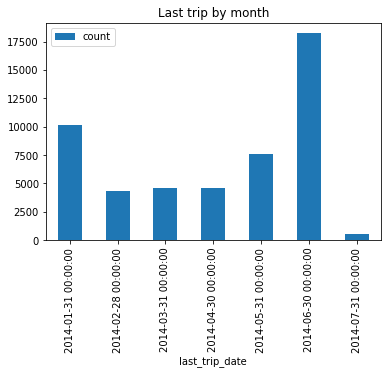

In [11]:
last_trip = data.filter(['last_trip_date'], axis=1)
last_trip['count'] = 1
last_trip = last_trip.set_index('last_trip_date')
ax = last_trip.groupby(pd.Grouper(freq='M')).count()
ax.plot(kind='bar')
plt.title("Last trip by month")
plt.show()


A new column 'retained' is created to account for active or inactive status of the driver.  1 if the driver has rides in the preceding 30 days and 0 if driver does not have a ride in the preceding 30 days

In [12]:
from datetime import datetime, timedelta
#Creating a new column 'retained' with a value of 1 if the driver has rides in the preceding 30 days 
#and 0 if driver does not have a ride in the preceding 30 days.

#adding one day to the last trip date recorded 'most_recent_date"
hours_to_add = 24
datetime_new = most_recent_date + timedelta(hours = hours_to_add)

#calculating if drivers' last trip is within 30 days
data['diff']=(pd.to_datetime(datetime_new)-data.last_trip_date).dt.days
data['retained']=pd.cut(data['diff'],bins = [0,30,99999],labels=[1,0]).astype(np.int8)


The following plot clearly shows that once aggregated, the number of inactive drivers is higher than the ones considered active or retained.  Only 36% of drivers were retained.



The percentage of drivers that was retained is: 36.6 %



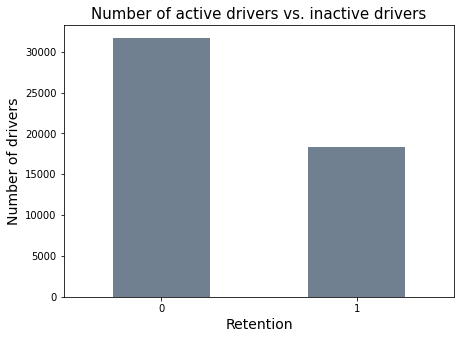

In [13]:

retention_percentage = round(len(data.loc[(data['retained']==1)])/len(data['retained']), 3)*100.0
print('The percentage of drivers that was retained is:',retention_percentage, '%' )
print()
plt.figure(figsize=(7,5))
retention = data['retained'].value_counts()
retention.plot(kind = 'bar', rot=0, y='Number of retained drivers', color = 'slategrey')
plt.title('Number of active drivers vs. inactive drivers', fontsize=15)
plt.xlabel('Retention', fontsize=14)
plt.ylabel('Number of drivers',fontsize=14)
plt.show()

Next, a new column 'sixth_month' is created to account for drivers that have been in the system for more than 5 months. This will be used in the model to account for drivers that are active in their sixth month.

In [14]:
#Creating a new column 'sixth_month' with a value of 1 if the driver has more than 
#152 days(5 months from Jan1 to June1) signed up.
#0 if the driver has less than 152 days.

data['signup_date'] = (pd.to_datetime(data.signup_date))
data['sixth_month_diff'] = (pd.to_datetime(most_recent_date)-(data.signup_date)).dt.days
data['sixth_month'] = pd.cut(data['sixth_month_diff'],bins = [0,152,99999],labels=[0,1]).astype(np.int8)

# Conversion of categorical variables to numerical values.
The data contains columns of categorical data that will be converted to numerical data.


In [15]:
# Converting 'ultimate_black_user' variable to a 1 if driver is an ultimate_black_user and a 0 if driver 
#is not an ultimate_black_user

data['ultimate_black_user'] = [1 if s == True else 0 for s in data['ultimate_black_user']]

In [16]:
#Variable 'city' has 4 distinct cities 

data['city'].unique()

array(["King's Landing", 'Astapor', 'Winterfell'], dtype=object)

In [17]:
#Column 'phone' has 2 distinct phone types and one None category 

data['phone'].unique()

array(['iPhone', 'Android', 'None'], dtype=object)

In [18]:
# One Hot Encoding is used to create columns to account for 4 cities and 3 phone categories
# This method will convert the category values into new columns and assigns a 1 or 0 (True/False) value to the column

data_enc = pd.get_dummies(data, columns=["city", "phone",])
data_enc.head()

,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,diff,retained,sixth_month_diff,sixth_month,city_Astapor,city_King's Landing,city_Winterfell,phone_Android,phone_None,phone_iPhone
0,4,2014-01-25,4.7,1.10,2014-06-17,15.4,1,46.2,3.67,5.0,15,1,157,1,0,1,0,0,0,1
1,0,2014-01-29,5.0,1.00,2014-05-05,0.0,0,50.0,8.26,5.0,58,0,153,1,1,0,0,1,0,0
2,3,2014-01-06,4.3,1.00,2014-01-07,0.0,0,100.0,0.77,5.0,176,0,176,1,1,0,0,0,0,1
3,9,2014-01-10,4.6,1.14,2014-06-29,20.0,1,80.0,2.36,4.9,3,1,172,1,0,1,0,0,0,1
4,14,2014-01-27,4.4,1.19,2014-03-15,11.8,0,82.4,3.13,4.9,109,0,155,1,0,0,1,1,0,0


## Finally, drivers that are in their sixth month (1) are selected to train the classification model that will predict whether or not they will be active in their sixth month.

In [19]:
train_data_enc = data_enc.loc[(data_enc['sixth_month'] == 1)]                    

Features DataFrame

In [20]:
train_data_enc.drop(['signup_date','last_trip_date','diff','sixth_month_diff'],axis=1)

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,retained,sixth_month,city_Astapor,city_King's Landing,city_Winterfell,phone_Android,phone_None,phone_iPhone
0,4,4.7,1.10,15.4,1,46.2,3.67,5.0,1,1,0,1,0,0,0,1
1,0,5.0,1.00,0.0,0,50.0,8.26,5.0,0,1,1,0,0,1,0,0
2,3,4.3,1.00,0.0,0,100.0,0.77,5.0,0,1,1,0,0,0,0,1
3,9,4.6,1.14,20.0,1,80.0,2.36,4.9,1,1,0,1,0,0,0,1
4,14,4.4,1.19,11.8,0,82.4,3.13,4.9,0,1,0,0,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49994,1,4.6,1.44,37.5,0,25.0,2.25,4.5,0,1,1,0,0,0,0,1
49995,0,5.0,1.00,0.0,0,100.0,5.63,4.2,1,1,0,1,0,0,0,1
49996,1,0.0,1.00,0.0,0,0.0,0.00,4.0,0,1,1,0,0,0,0,1
49998,2,3.0,1.00,0.0,0,100.0,4.58,3.5,0,1,1,0,0,0,0,1


In [22]:
# Removing apostrophe from "King's Landing" name for modeling

train_data_enc.columns = train_data_enc.columns.str.replace("'"," ")

In [23]:
train_data_enc.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 46429 entries, 0 to 49999
Data columns (total 20 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   trips_in_first_30_days  46429 non-null  int64         
 1   signup_date             46429 non-null  datetime64[ns]
 2   avg_rating_of_driver    46429 non-null  float64       
 3   avg_surge               46429 non-null  float64       
 4   last_trip_date          46429 non-null  datetime64[ns]
 5   surge_pct               46429 non-null  float64       
 6   ultimate_black_user     46429 non-null  int64         
 7   weekday_pct             46429 non-null  float64       
 8   avg_dist                46429 non-null  float64       
 9   avg_rating_by_driver    46429 non-null  float64       
 10  diff                    46429 non-null  int64         
 11  retained                46429 non-null  int8          
 12  sixth_month_diff        46429 non-null  int64 

# Splitting data into train and test data

In [24]:
from sklearn.model_selection import train_test_split

Xtrain, Xtest, ytrain, ytest = train_test_split(train_data_enc[[
'trips_in_first_30_days', 
'avg_rating_of_driver', 
'avg_surge',
'surge_pct', 
'weekday_pct', 
'avg_dist', 
'avg_rating_by_driver', 
'city_Astapor',
'city_King s Landing',
'city_Winterfell',
'phone_Android',
'phone_None',
'phone_iPhone',
'ultimate_black_user',
      ]], train_data_enc.retained.values, test_size=.20, random_state=42)

In [25]:
print('The train data has',len(Xtrain),'samples')
print('The test data has',len(Xtest),'samples')

The train data has 37143 samples
The test data has 9286 samples


# Scaling the Data

In [26]:
from sklearn import preprocessing
scaler = preprocessing.StandardScaler()

In [27]:
#scaling train data
Xtrain = pd.DataFrame(scaler.fit_transform(Xtrain), columns=Xtrain.columns).values

In [28]:
#scaling test data

Xtest = pd.DataFrame(scaler.fit_transform(Xtest), columns=Xtest.columns).values

# Building a XGBoost Model to predict whether or not a user will be active in their 6th month.  XGBoost was selected as a classification model that will predict 1 if the driver will be active and 0 if the driver will inactive.

In [29]:
from numpy import loadtxt
from xgboost import XGBClassifier

Finding the best hyperparmeters

In [30]:
from sklearn.model_selection import RandomizedSearchCV
import time


Xtrain, ytrain, Xtest, ytest = Xtrain, ytrain, Xtest, ytest
clf = XGBClassifier()
param_grid = {

        'silent': [False],

        'max_depth': [6, 10, 15, 20],

        'learning_rate': [0.001, 0.01, 0.1, 0.2, 0,3]}


randomized_clf = RandomizedSearchCV(clf, param_grid, n_iter=3, n_jobs=1, verbose=2, cv=2,
scoring= 'accuracy', refit=False, random_state=42)
print("Randomized search..")
search_time_start = time.time()
randomized_clf.fit(Xtrain, ytrain)
print("Randomized search time:", time.time() - search_time_start)

best_score = np.mean(randomized_clf.best_score_)
best_params = randomized_clf.best_params_
print("Best score: {}".format(best_score))
print("Best params: ")

for param_name in sorted(best_params.keys()):

    print('%s: %r' % (param_name, best_params[param_name]))

Randomized search..
Fitting 2 folds for each of 3 candidates, totalling 6 fits
[CV] silent=False, max_depth=6, learning_rate=0.1 ....................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ..... silent=False, max_depth=6, learning_rate=0.1, total=   2.3s
[CV] silent=False, max_depth=6, learning_rate=0.1 ....................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.3s remaining:    0.0s


[CV] ..... silent=False, max_depth=6, learning_rate=0.1, total=   2.2s
[CV] silent=False, max_depth=6, learning_rate=0 ......................
[CV] ....... silent=False, max_depth=6, learning_rate=0, total=   2.3s
[CV] silent=False, max_depth=6, learning_rate=0 ......................
[CV] ....... silent=False, max_depth=6, learning_rate=0, total=   2.4s
[CV] silent=False, max_depth=6, learning_rate=0.001 ..................
[CV] ... silent=False, max_depth=6, learning_rate=0.001, total=   2.3s
[CV] silent=False, max_depth=6, learning_rate=0.001 ..................
[CV] ... silent=False, max_depth=6, learning_rate=0.001, total=   2.3s
Randomized search time: 13.854111909866333
Best score: 0.7940123892850617
Best params: 
learning_rate: 0.1
max_depth: 6
silent: False


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:   13.8s finished


In [31]:
model = XGBClassifier(learning_rate = 0.1, max_depth = 6, silent = False)
model.fit(Xtrain, ytrain)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=False, subsample=1, verbosity=1)

# Making model predictions

In [32]:
# make predictions for test data
y_pred = model.predict(Xtest)
predictions = [round(value) for value in y_pred]

In [33]:
from sklearn.metrics import accuracy_score
# evaluate predictions
accuracy = accuracy_score(ytest, predictions)
print("Prediction accuracy: %.2f%%" % (accuracy * 100.0))

Prediction accuracy: 79.25%


# Feature Importance Plot

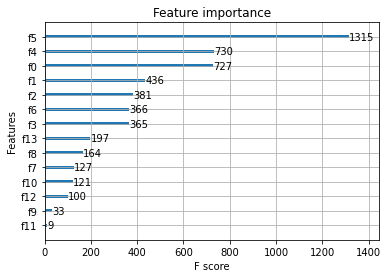

In [34]:
from xgboost import plot_importance
plot_importance(model)

The model produced an prediction accuracy of 79.25% on the test unseen data which serves as good base for a prediction model. The model can generatlize well on new data.  

The three most important features in predicting whether a driver will be active in their sixth month are:

1.  'avg_dist'
2.  'weekday_pct'
1.  'trips_in_first_30_days'
1.  'avg_rating_of_driver'
2.  'avg_surge',
1.  'avg_rating_by_driver'


The features provide good insights into what features Ultimate management should be monitoring.  Important features indicate the level of activity of riders and have more weight that the ones indicating geography or device used.  

Also, ratings play an important part in the prediction.  Therefore, a machine learning model that monitors ratings could be a good compliment to the prediction model.



